In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='BDNRB.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('BDNRB.zip')
f.keys()
!unzip BDNRB.zip

Streaming output truncated to the last 5000 lines.
  inflating: BDNRB/train/063/311.jpg  
  inflating: BDNRB/train/063/312.jpg  
  inflating: BDNRB/train/063/314.jpg  
  inflating: BDNRB/train/063/315.jpg  
  inflating: BDNRB/train/063/316.jpg  
  inflating: BDNRB/train/063/319.jpg  
  inflating: BDNRB/train/063/320.jpg  
  inflating: BDNRB/train/063/326.jpg  
  inflating: BDNRB/train/063/327.jpg  
  inflating: BDNRB/train/063/328.jpg  
  inflating: BDNRB/train/063/329.jpg  
  inflating: BDNRB/train/063/330.jpg  
  inflating: BDNRB/train/063/331.jpg  
  inflating: BDNRB/train/063/338.jpg  
  inflating: BDNRB/train/063/339.jpg  
  inflating: BDNRB/train/063/340.jpg  
  inflating: BDNRB/train/063/341.jpg  
  inflating: BDNRB/train/063/343.jpg  
  inflating: BDNRB/train/063/344.jpg  
  inflating: BDNRB/train/063/345.jpg  
  inflating: BDNRB/train/063/346.jpg  
  inflating: BDNRB/train/063/347.jpg  
  inflating: BDNRB/train/063/349.jpg  
  inflating: BDNRB/train/063/350.jpg  
  inflating: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.13.0


In [ ]:
train_dir = '/content/BDNRB/train'
validation_dir = '/content/BDNRB/validation'
test_dir = '/content/BDNRB/test'



BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 24000 files belonging to 64 classes.
Found 4800 files belonging to 64 classes.
Found 3200 files belonging to 64 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomContrast(factor=0.1),
        layers.RandomBrightness(factor=0.1),

    ]
)

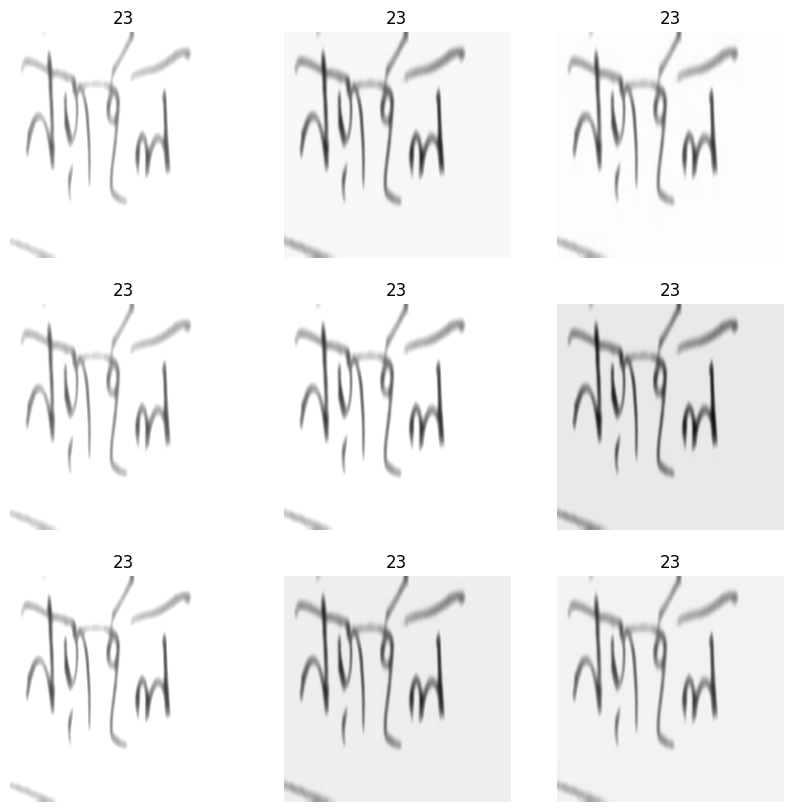

In [ ]:
import numpy as np

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.ResNet50(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
nb_classes = 64
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation="relu")(x)

outputs = Dense(nb_classes, activation="softmax")(x)
#outputs = keras.layers.Dense(13)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy'])

In [ ]:
epochs = 10
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset,callbacks=[callback])

Epoch 1/10
750/750 [==============================] - 118s 131ms/step - loss: 3.5888 - accuracy: 0.1088 - val_loss: 2.9896 - val_accuracy: 0.2165
Epoch 2/10
750/750 [==============================] - 98s 130ms/step - loss: 2.8715 - accuracy: 0.2379 - val_loss: 2.5841 - val_accuracy: 0.3048
Epoch 3/10
750/750 [==============================] - 98s 130ms/step - loss: 2.5604 - accuracy: 0.3101 - val_loss: 2.3154 - val_accuracy: 0.3744
Epoch 4/10
750/750 [==============================] - 98s 130ms/step - loss: 2.3410 - accuracy: 0.3632 - val_loss: 2.0908 - val_accuracy: 0.4254
Epoch 5/10
750/750 [==============================] - 98s 130ms/step - loss: 2.1817 - accuracy: 0.4002 - val_loss: 1.9472 - val_accuracy: 0.4731
Epoch 6/10
750/750 [==============================] - 98s 130ms/step - loss: 2.0544 - accuracy: 0.4328 - val_loss: 1.7915 - val_accuracy: 0.5165
Epoch 7/10
750/750 [==============================] - 97s 130ms/step - loss: 1.9533 - accuracy: 0.4623 - val_loss: 1.7631 - val_a

In [ ]:
scores = model.evaluate(test_dataset)

100/100 [==============================] - 11s 106ms/step - loss: 1.4566 - accuracy: 0.5997


In [ ]:
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

In [ ]:
epochs = 100
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset,callbacks=[callback])

Epoch 1/100
750/750 [==============================] - 321s 376ms/step - loss: 0.9689 - accuracy: 0.7117 - val_loss: 0.4749 - val_accuracy: 0.8602
Epoch 2/100
750/750 [==============================] - 280s 373ms/step - loss: 0.3966 - accuracy: 0.8752 - val_loss: 0.2483 - val_accuracy: 0.9290
Epoch 3/100
750/750 [==============================] - 281s 375ms/step - loss: 0.2134 - accuracy: 0.9316 - val_loss: 0.1248 - val_accuracy: 0.9613
Epoch 4/100
750/750 [==============================] - 286s 381ms/step - loss: 0.1228 - accuracy: 0.9609 - val_loss: 0.0552 - val_accuracy: 0.9837
Epoch 5/100
750/750 [==============================] - 281s 374ms/step - loss: 0.0964 - accuracy: 0.9692 - val_loss: 0.0618 - val_accuracy: 0.9833
Epoch 6/100
750/750 [==============================] - 281s 375ms/step - loss: 0.0701 - accuracy: 0.9767 - val_loss: 0.0475 - val_accuracy: 0.9860
Epoch 7/100
750/750 [==============================] - 286s 381ms/step - loss: 0.0609 - accuracy: 0.9810 - val_loss: 0

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

In [ ]:
scores = model.evaluate(test_dataset)

100/100 [==============================] - 11s 105ms/step - loss: 0.0290 - accuracy: 0.9934


In [ ]:
class_names = test_dataset.class_names
class_names

['000',
 '001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063']

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 27ms/step


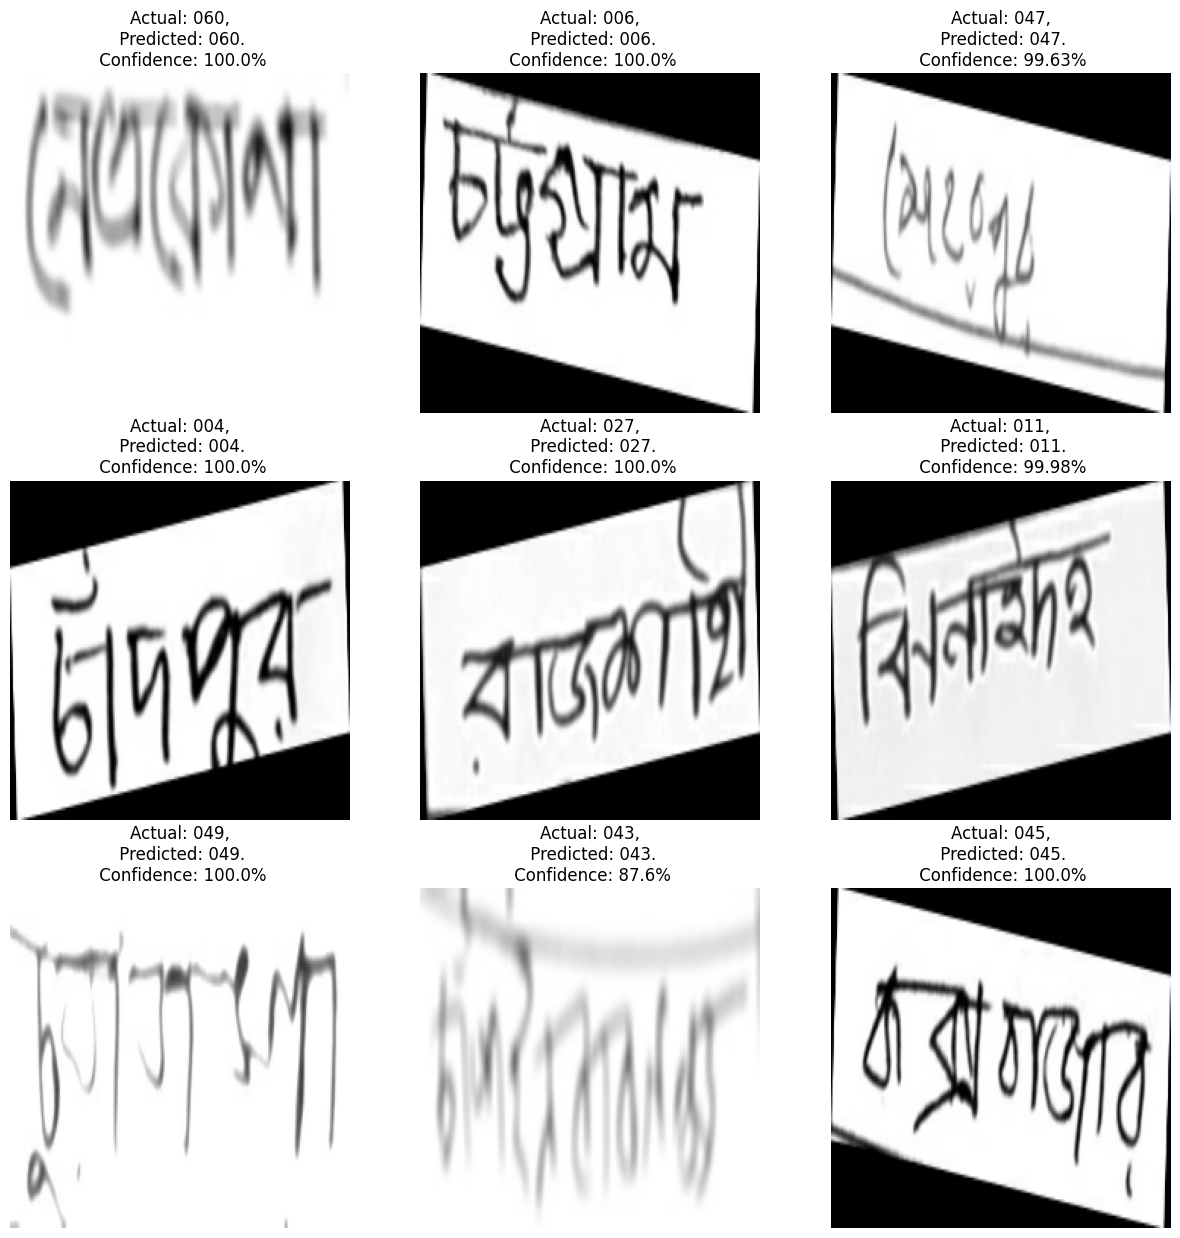

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 29ms/step


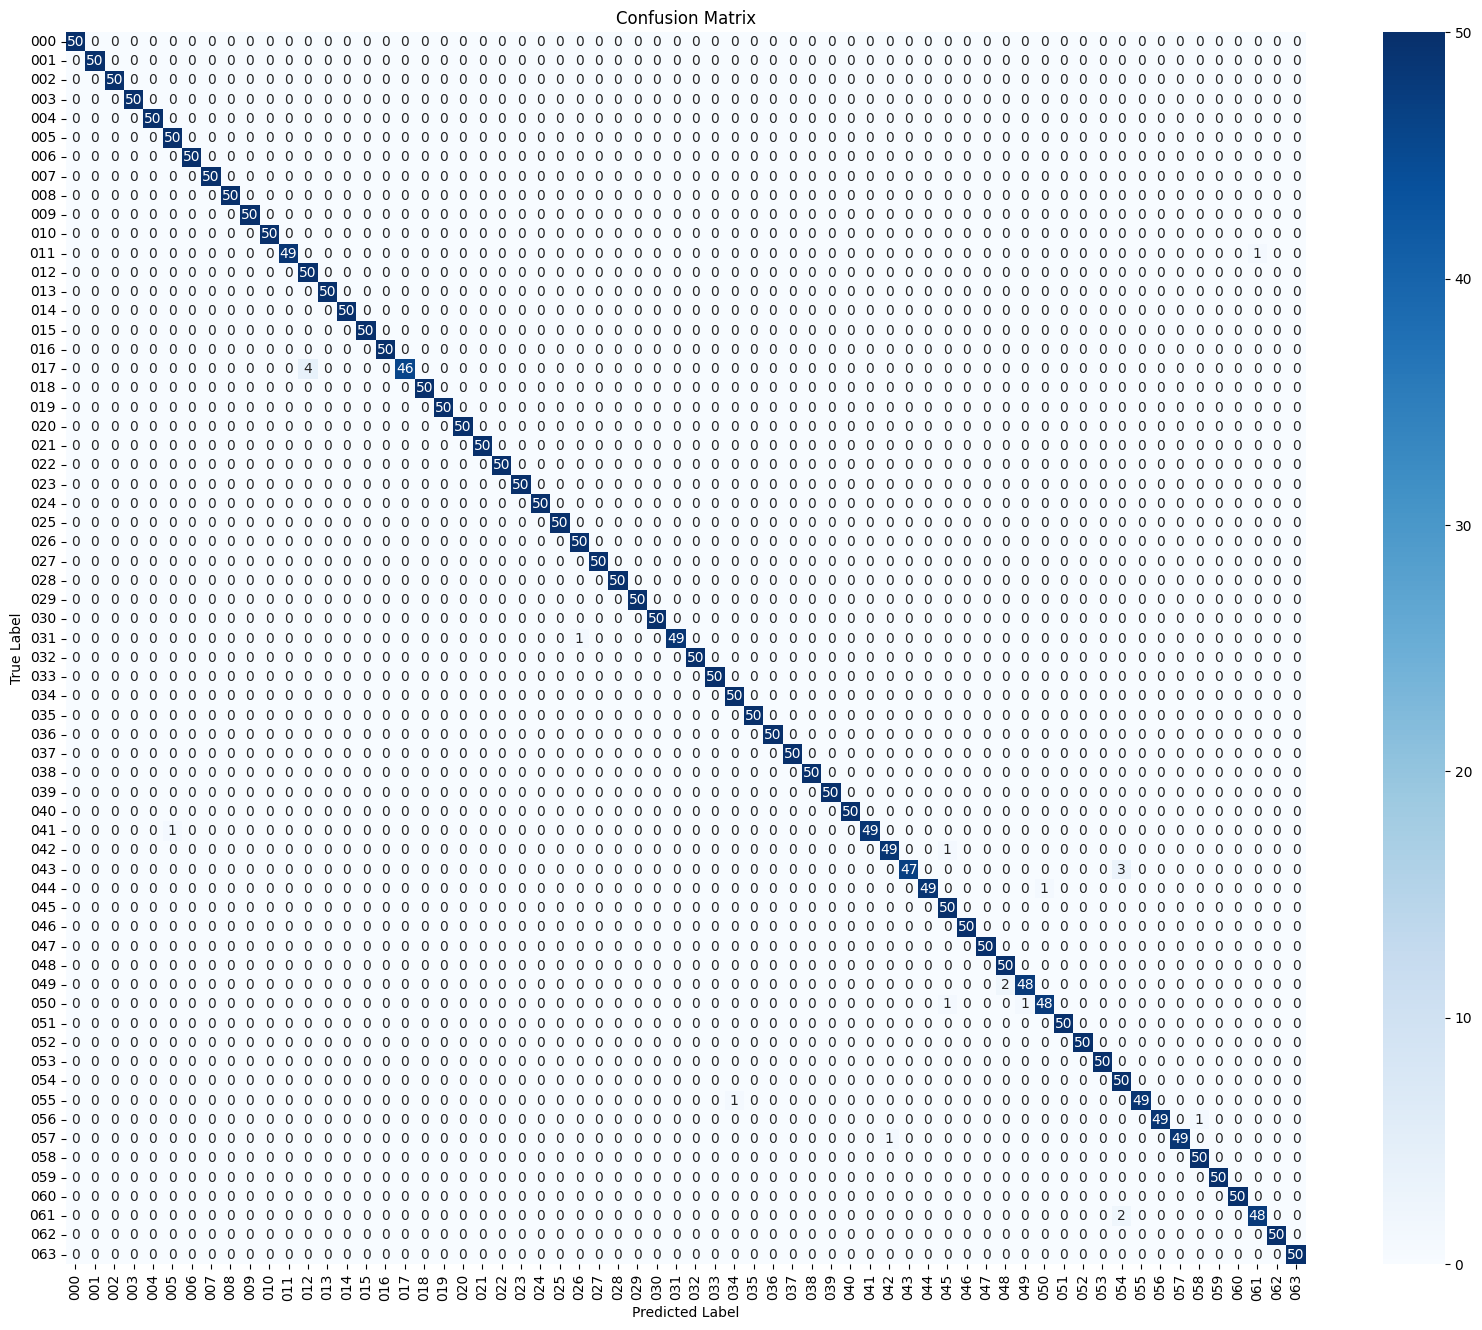

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
test_dataset = test_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

# Replace 'Class 0' and 'Class 1' with the actual class names from your dataset

# Create empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to obtain true and predicted labels
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

1/1 [==============================] - 0s 23ms/step
F1 Score: 0.993451392248664
Precision: 0.9937255921210754
Recall: 0.9934375
ROC-AUC Score: 0.9999782738095239


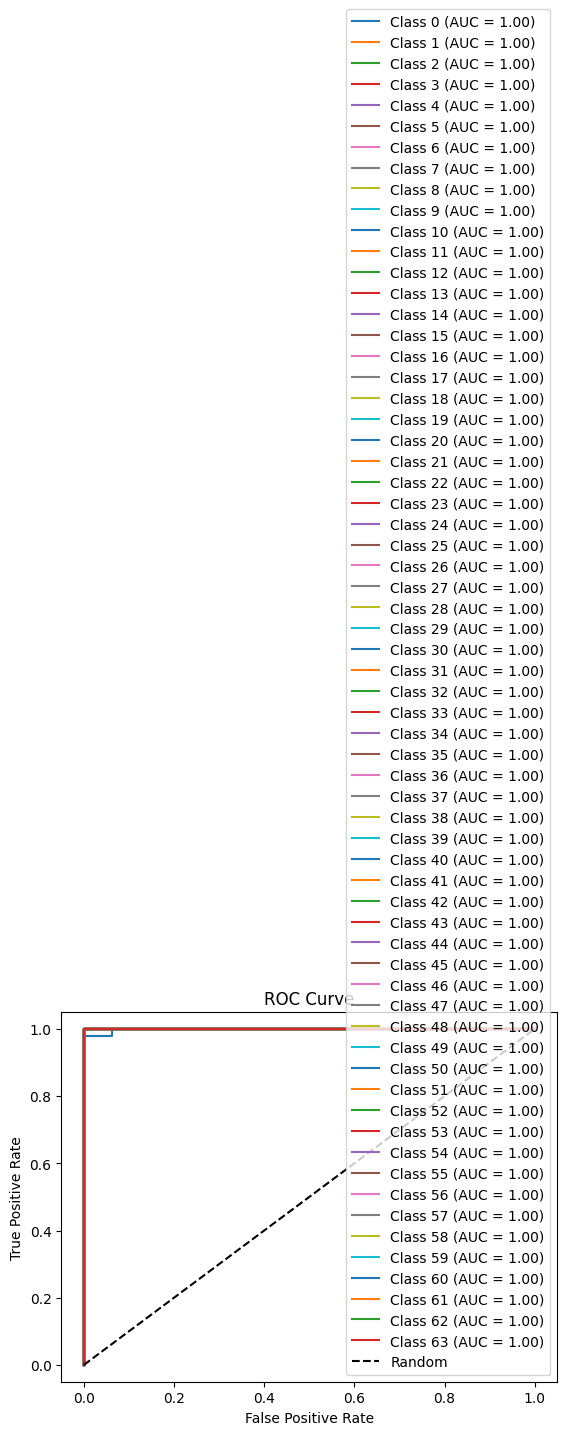

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# After model.fit(...)
test_dataset = test_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

y_true = []
y_pred = []

for x_val, y_val in test_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    y_pred.append(model.predict(x_val)[0])  # Append predicted probabilities (raw output)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(nb_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
